In [42]:
import pandas as pd
import numpy as np

# Load and clean the data
df = pd.read_csv("D:/kadi-lesson/Git/metdata/FORM626.csv", encoding='latin1')
df.replace(r'^\s*$|^\.\.\.$', np.nan, regex=True, inplace=True)
df = df.apply(pd.to_numeric, errors='coerce')
df.dropna(how='all', inplace=True)
df.reset_index(drop=True, inplace=True)

# Create 'Date' column from YEAR and MONTH
df['Date'] = df['YEAR'].astype(int).astype(str) + '-' + df['MONTH'].astype(int).astype(str).str.zfill(2)

# Reorder columns to make 'Date' the second column
first_col = df.columns.get_loc("STN_ID")
cols = df.columns.tolist()
cols.insert(first_col + 1, cols.pop(cols.index("Date")))
df = df[cols]

# Exclude from aggregation
excluded_columns = ['YEAR', 'MONTH', 'DAY', 'Date']

# Numeric columns excluding specific ones
numeric_cols = [col for col in df.select_dtypes(include='number').columns if col not in excluded_columns + ['STN_ID']]

# Group by STN_ID and calculate stats
summary_stats = df.groupby("STN_ID")[numeric_cols].agg(['min', 'max', 'mean'])

# Total PRECIP if available
if "PRECIP" in numeric_cols:
    precip_total = df.groupby("STN_ID")["PRECIP"].sum().rename(("PRECIP", "total"))
    final_stats = pd.concat([summary_stats, precip_total], axis=1)
else:
    final_stats = summary_stats

# Save to CSV
#final_stats.to_csv("D:/kadi-lesson/Git/metdata/FORM626_Analyzed_7.csv")

# Preview
#print(df.head())


In [43]:
# Group by STN_ID and Date
grouped = df.groupby(["STN_ID", "Date"])[numeric_cols].agg(['min', 'max', 'mean'])

# Add total PRECIP if available
if "PRECIP" in numeric_cols:
    precip_total = df.groupby(["STN_ID", "Date"])["PRECIP"].sum().rename(("PRECIP", "total"))
    final_stats = pd.concat([grouped, precip_total], axis=1)

# Save to CSV
#final_stats.to_csv("D:/kadi-lesson/Git/metdata/FORM626_Analyzed4.csv")


In [44]:
# Smart rounding function
def smart_round(val):
    if pd.isna(val):
        return val
    return round(val, 1) if not float(val).is_integer() else int(val)

# Apply smart_round only to numeric columns
for col in final_stats.select_dtypes(include='number').columns:
    final_stats[col] = final_stats[col].apply(smart_round)

final_stats.to_csv("D:/kadi-lesson/Git/metdata/FORM626_Analyzed6.csv")

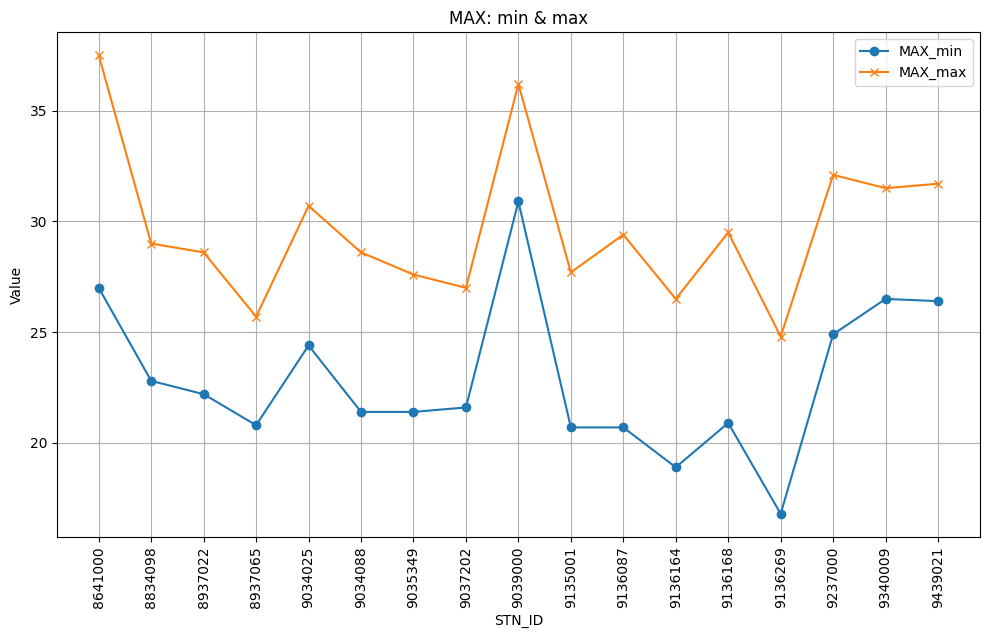

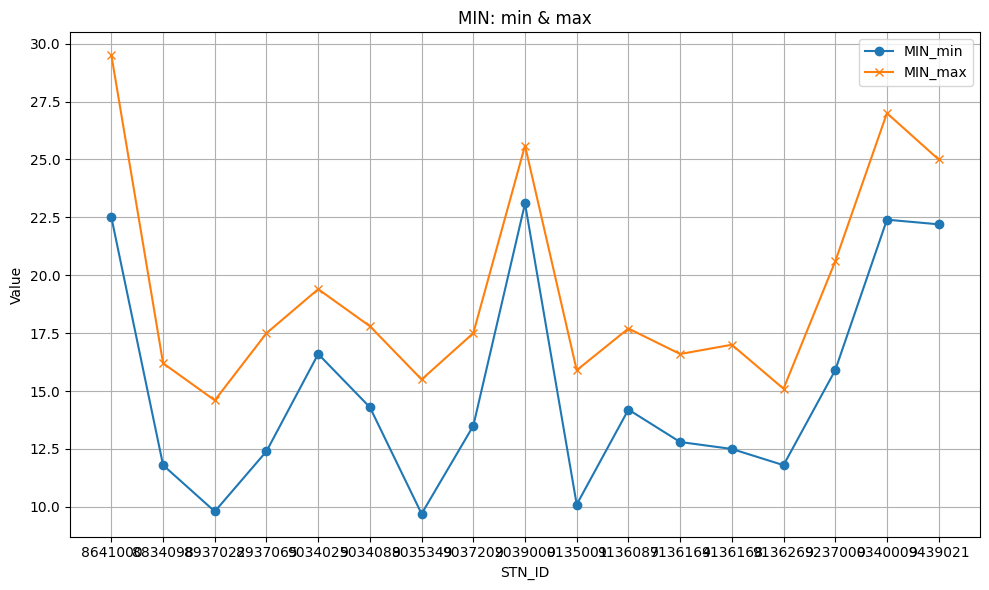

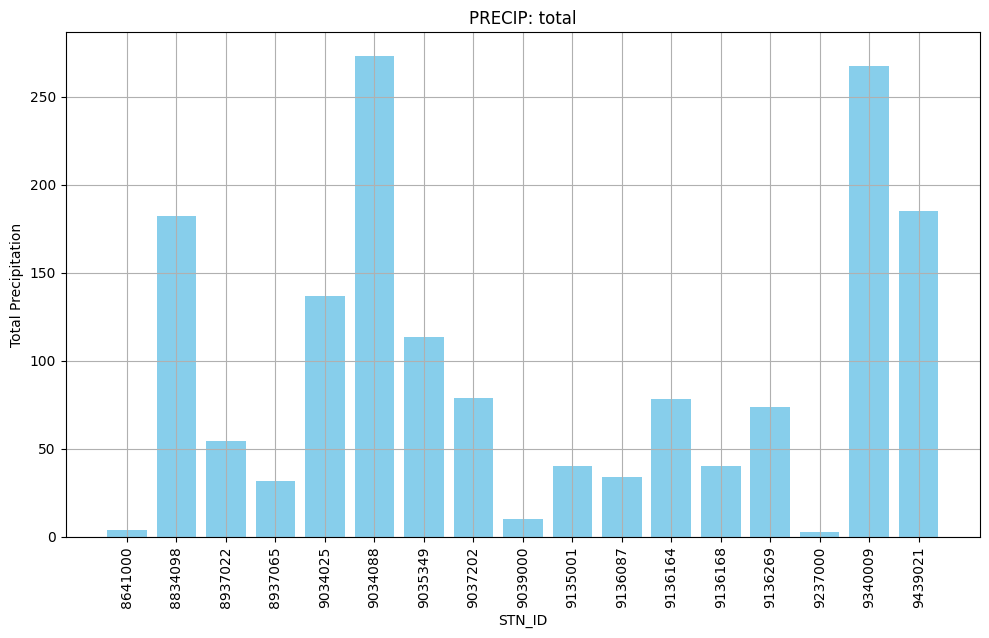

In [ ]:
import matplotlib.pyplot as plt

# Flatten columns if they're multi-indexed (e.g. ('MAX', 'min') -> 'MAX_min')
if isinstance(final_stats.columns[0], tuple):
    final_stats.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in final_stats.columns]

# Reset the index to move STN_ID to a column
final_stats.reset_index(inplace=True)

# Extract STN_IDs for x-axis (they are now in the DataFrame, not the index)
stations = final_stats['STN_ID'].astype(str)

# Plot 1: MAX_min and MAX_max
plt.figure(figsize=(10, 6))
plt.plot(stations, final_stats['MAX_min'], marker='o', label='MAX_min')
plt.plot(stations, final_stats['MAX_max'], marker='x', label='MAX_max')
plt.title('MAX: min & max')
plt.xlabel('STN_ID')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

# Save the MAX plot separately
plt.tight_layout()
plt.xticks(rotation=90)
plt.savefig("D:/kadi-lesson/Git/metdata/FORM626_MAX_Plot.png", format='png')

# Plot 2: MIN_min and MIN_max
plt.figure(figsize=(10, 6))
plt.plot(stations, final_stats['MIN_min'], marker='o', label='MIN_min')
plt.plot(stations, final_stats['MIN_max'], marker='x', label='MIN_max')
plt.title('MIN: min & max')
plt.xlabel('STN_ID')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

# Save the MIN plot separately
plt.tight_layout()
plt.xticks(rotation=90)
plt.savefig("D:/kadi-lesson/Git/metdata/FORM626_MIN_Plot.png", format='png')

# Plot 3: PRECIP_total
plt.figure(figsize=(10, 6))
plt.bar(stations, final_stats['PRECIP_total'], color='skyblue')
plt.title('PRECIP: total')
plt.xlabel('STN_ID')
plt.ylabel('Total Precipitation')
plt.grid(True)

# Save the PRECIP plot separately
plt.tight_layout()
plt.xticks(rotation=90)
plt.savefig("D:/kadi-lesson/Git/metdata/FORM626_PRECIP_Plot.png", format='png')

# Show the plots
plt.show()
